In [1]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers.core import Dense
from keras.optimizers import RMSprop
from keras.layers import LSTM
from rbf_layer import RBFLayer, InitCentersRandom
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression

In [2]:
def roll_beta(window_size, stock, market):
    data = {'X': market, 'Y': stock}
    df = pd.DataFrame(data)
    cov = df.X.rolling(window=window_size).cov(df.Y)
    var = df.X.rolling(window=window_size).var()
    roling_beta = cov/var
    return np.array(roling_beta[window_size - 1:])

In [3]:
def return_from_stock(stock_data):
    stock = pd.read_csv(f"{stock_data}")
    #creating new column 'return' it is percentage change between current and last month close price
    stock['return'] = stock.Zamkniecie.pct_change()
    return np.array(stock['return'][1:]) # first value is NaN so [1:]

In [4]:
wig_20_return = return_from_stock('wig20_m.csv')
peo_return = return_from_stock('peo_m.csv')

In [5]:
peo_roll_beta = roll_beta(36, peo_return, wig_20_return)

In [6]:
peo_roll_beta

array([0.9772635 , 0.97014216, 1.00021326, 1.00341387, 0.99066662,
       1.00436244, 0.99490991, 1.02171093, 1.03098369, 1.03367474,
       1.051477  , 1.0441973 , 1.06097197, 1.06000448, 1.03501676,
       1.04392938, 1.05036511, 1.06179624, 1.04459305, 1.05446398,
       1.04846115, 1.0680065 , 1.07123908, 1.07525705, 1.06774364,
       1.08922898, 1.13356561, 1.12231121, 1.11750739, 1.11221958,
       1.11222089, 1.15435166, 1.18812062, 1.26028061, 1.23078474,
       1.43892495, 1.44945814, 1.44257389, 1.49245589, 1.48736234,
       1.48676661, 1.49808716, 1.51245944, 1.49931122, 1.49980717,
       1.5056696 , 1.46281084, 1.46229541, 1.45473297, 1.45703139,
       1.42105982, 1.42173266, 1.42370527, 1.43551197, 1.44929252,
       1.42299995, 1.45985696, 1.45545443, 1.44527129, 1.4413922 ,
       1.44229289, 1.45366658, 1.43358319, 1.40905135, 1.40282212,
       1.47843879, 1.45342916, 1.42107272, 1.42991674, 1.33643484,
       1.37197186, 1.06860085, 1.05577774, 1.06599178, 0.92549

In [22]:
# creating training dataset
df_data = pd.DataFrame({
    'target': peo_roll_beta,
    't-1': np.roll(peo_roll_beta, 1),
    't-2': np.roll(peo_roll_beta, 2),
    't-3': np.roll(peo_roll_beta, 3),
    't-4': np.roll(peo_roll_beta, 4),
    't-5': np.roll(peo_roll_beta, 5)
})


In [23]:
df_data = df_data.iloc[5:]
df_data

,target,t-1,t-2,t-3,t-4,t-5
5,1.004362,0.990667,1.003414,1.000213,0.970142,0.977263
6,0.994910,1.004362,0.990667,1.003414,1.000213,0.970142
7,1.021711,0.994910,1.004362,0.990667,1.003414,1.000213
8,1.030984,1.021711,0.994910,1.004362,0.990667,1.003414
9,1.033675,1.030984,1.021711,0.994910,1.004362,0.990667
...,...,...,...,...,...,...
200,1.320562,1.322314,1.325707,1.396829,1.325983,1.353047
201,1.368290,1.320562,1.322314,1.325707,1.396829,1.325983
202,1.234932,1.368290,1.320562,1.322314,1.325707,1.396829
203,1.314584,1.234932,1.368290,1.320562,1.322314,1.325707


In [24]:
X = df_data.iloc[:, -5:]
X

,t-1,t-2,t-3,t-4,t-5
5,0.990667,1.003414,1.000213,0.970142,0.977263
6,1.004362,0.990667,1.003414,1.000213,0.970142
7,0.994910,1.004362,0.990667,1.003414,1.000213
8,1.021711,0.994910,1.004362,0.990667,1.003414
9,1.030984,1.021711,0.994910,1.004362,0.990667
...,...,...,...,...,...
200,1.322314,1.325707,1.396829,1.325983,1.353047
201,1.320562,1.322314,1.325707,1.396829,1.325983
202,1.368290,1.320562,1.322314,1.325707,1.396829
203,1.234932,1.368290,1.320562,1.322314,1.325707


In [25]:
X = X[X.columns[::-1]]
X

,t-5,t-4,t-3,t-2,t-1
5,0.977263,0.970142,1.000213,1.003414,0.990667
6,0.970142,1.000213,1.003414,0.990667,1.004362
7,1.000213,1.003414,0.990667,1.004362,0.994910
8,1.003414,0.990667,1.004362,0.994910,1.021711
9,0.990667,1.004362,0.994910,1.021711,1.030984
...,...,...,...,...,...
200,1.353047,1.325983,1.396829,1.325707,1.322314
201,1.325983,1.396829,1.325707,1.322314,1.320562
202,1.396829,1.325707,1.322314,1.320562,1.368290
203,1.325707,1.322314,1.320562,1.368290,1.234932


In [27]:
y = df_data.target
y

5      1.004362
6      0.994910
7      1.021711
8      1.030984
9      1.033675
         ...   
200    1.320562
201    1.368290
202    1.234932
203    1.314584
204    1.327663
Name: target, Length: 200, dtype: float64

In [28]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20, random_state=0, shuffle=False)

Text(0.5, 1.0, 'Beta value (36 mounth) all data ')

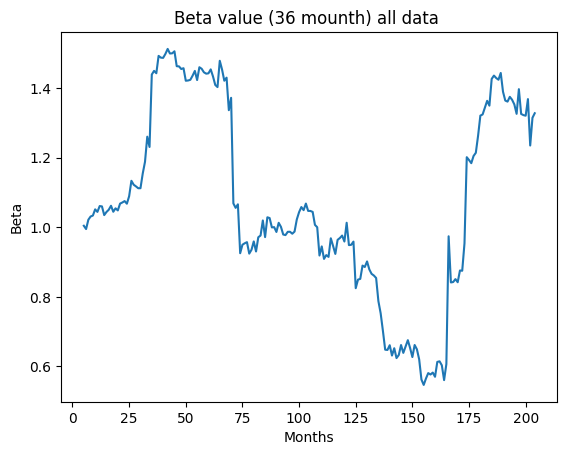

In [30]:
plt.plot(y)
plt.xlabel('Months')
plt.ylabel('Beta')
plt.title('Beta value (36 mounth) all data ')

In [31]:
y_test

165    0.606939
166    0.974103
167    0.841483
168    0.842637
169    0.851121
170    0.842051
171    0.875850
172    0.875106
173    0.953912
174    1.201371
175    1.193164
176    1.184191
177    1.204824
178    1.214017
179    1.263135
180    1.320789
181    1.324159
182    1.343358
183    1.363312
184    1.349455
185    1.426222
186    1.435857
187    1.428769
188    1.423958
189    1.443389
190    1.389460
191    1.364066
192    1.361070
193    1.374800
194    1.366442
195    1.353047
196    1.325983
197    1.396829
198    1.325707
199    1.322314
200    1.320562
201    1.368290
202    1.234932
203    1.314584
204    1.327663
Name: target, dtype: float64

In [101]:
def single_plot(y_pred, y_real, title):
    x = np.arange(1, len(y_pred) + 1)
    plt.plot(x,y_real, label='real')
    plt.plot(x,y_pred, label='predicted')
    plt.xlabel('day')
    plt.ylabel('month')
    plt.legend()
    plt.title(title)
    return plt.plot()

In [102]:
def generate_plots(y_pred_train, y_pred_test, y_train, y_test, title_1, title_2, to_png, png_name):
    fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(8, 6))

    ax = axes[0]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_train, y_train, title_1)

    ax = axes[1]  # Wybór odpowiedniej osi
    plt.sca(ax)  # Ustawienie bieżącej osi
    single_plot(y_pred_test, y_test, title_2)

    plt.tight_layout()
    if to_png:
        plt.savefig(f'plots/{png_name}.png')
    plt.show()

## Bulding RBF network model

In [94]:
model = Sequential()
rbflayer = RBFLayer(10,
                    initializer=InitCentersRandom(X_train),
                    betas=2.0,
                    input_shape=(5,))
model.add(rbflayer)
model.add(Dense(1))

model.compile(loss='mean_squared_error',
              optimizer=RMSprop())


model.fit(X_train, y_train,
          batch_size=10,
          epochs=200,
          verbose=1)

Epoch 1/200
16/16 [==============================] - 0s 1ms/step - loss: 1.3426
Epoch 2/200
16/16 [==============================] - 0s 1ms/step - loss: 1.1305
Epoch 3/200
16/16 [==============================] - 0s 2ms/step - loss: 0.9806
Epoch 4/200
16/16 [==============================] - 0s 2ms/step - loss: 0.8511
Epoch 5/200
16/16 [==============================] - 0s 668us/step - loss: 0.7368
Epoch 6/200
16/16 [==============================] - 0s 1ms/step - loss: 0.6378
Epoch 7/200
16/16 [==============================] - 0s 2ms/step - loss: 0.5467
Epoch 8/200
16/16 [==============================] - 0s 2ms/step - loss: 0.4645
Epoch 9/200
16/16 [==============================] - 0s 1ms/step - loss: 0.3878
Epoch 10/200
16/16 [==============================] - 0s 2ms/step - loss: 0.3166
Epoch 11/200
16/16 [==============================] - 0s 1ms/step - loss: 0.2571
Epoch 12/200
16/16 [==============================] - 0s 1ms/step - loss: 0.2019
Epoch 13/200
16/16 [===============

2/2 [==============================] - 0s 2ms/step


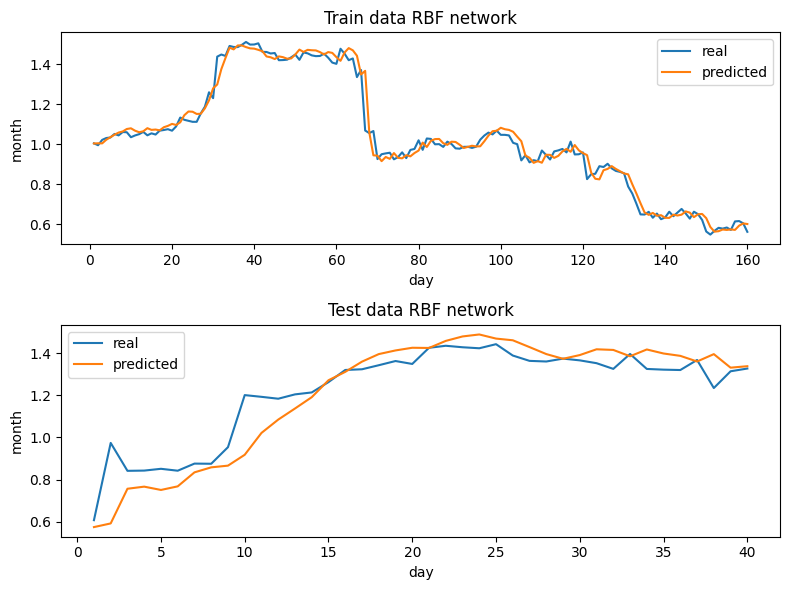

In [103]:
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)
generate_plots(y_pred_train, y_pred_test, y_train, y_test, 'Train data RBF network', 'Test data RBF network', False, 'xyz')

In [106]:
mse_train = mean_squared_error(y_train, y_pred_train)
mae_train = mean_absolute_error(y_train, y_pred_train)
r2_train = r2_score(y_train, y_pred_train)

mse_test = mean_squared_error(y_test, y_pred_test)
mae_test = mean_absolute_error(y_test, y_pred_test)
r2_test = r2_score(y_test, y_pred_test)

print("MSE:", mse_train)
print("MAE:", mae_train)
print("R^2:", r2_train)

MSE: 0.0017487223564813218
MAE: 0.02694363528107645
R^2: 0.9764394536404774


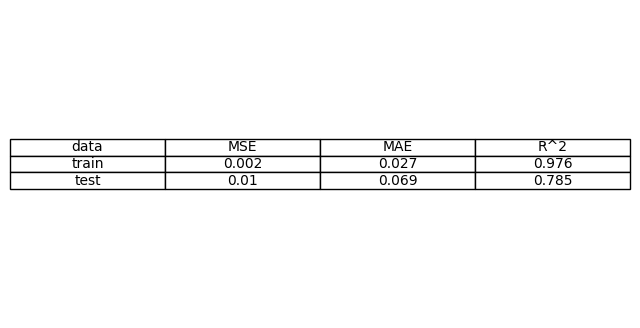

In [114]:
import pandas as pd
import matplotlib.pyplot as plt

# Tworzenie tabeli
data = {'data': ['train', 'test'],
        'MSE': [round(mse_train, 3), round(mse_test, 3)],
        'MAE': [round(mae_train, 3), round(mae_test, 3)],
        'R^2': [round(r2_train, 3), round(r2_test, 3)]
        }

df = pd.DataFrame(data)

# Tworzenie wykresu tabeli
fig, ax = plt.subplots(figsize=(8, 4))  # Ustalenie rozmiaru wykresu
ax.axis('off')  # Wyłączenie osi

table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')
# Zapisywanie tabeli jako obraz PNG
plt.savefig('tabela.png', bbox_inches='tight', pad_inches=0.5)

In [46]:
y_pred = model.predict(X_test)

2/2 [==============================] - 0s 0s/step


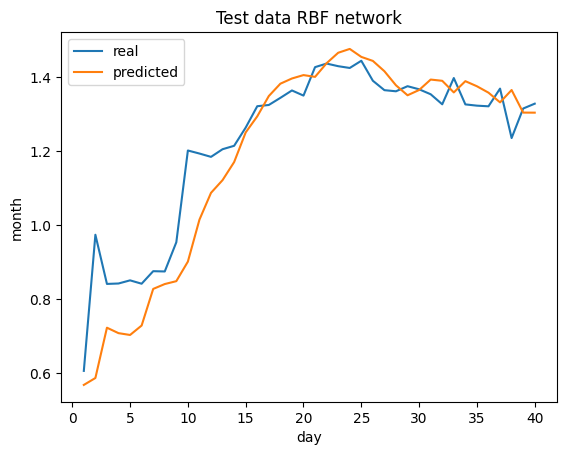

In [47]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_test, label='real')
plt.plot(x,y_pred, label='predicted')
plt.xlabel('day')
plt.ylabel('month')
plt.legend()
plt.title('Test data RBF network')
plt.show()

In [48]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [49]:
print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 0.010587971802462737
MAE: 0.06958643457458039
R^2: 0.7723477141053403


## Bulding XGBRegressor model

In [50]:
from xgboost import XGBRegressor
my_model = XGBRegressor(n_estimators=1000)
my_model.fit(X_train, y_train, verbose=False)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, gpu_id=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             n_estimators=1000, n_jobs=None, num_parallel_tree=None,
             predictor=None, random_state=None, ...)

In [51]:
y_pred = my_model.predict(X_train)

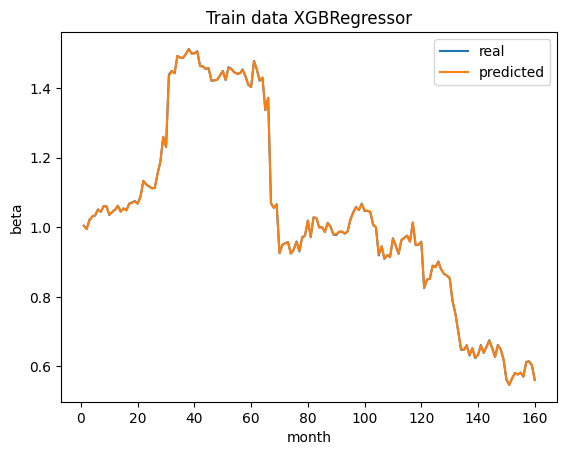

In [52]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_train, label='real')
plt.plot(x,y_pred, label='predicted')
plt.xlabel('month')
plt.ylabel('beta')
plt.legend()
plt.title('Train data XGBRegressor')
plt.show()

In [53]:
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 1.0901290997311884e-06
MAE: 0.0007558233111835032
R^2: 0.9999853126843739


In [54]:
y_pred = my_model.predict(X_test)

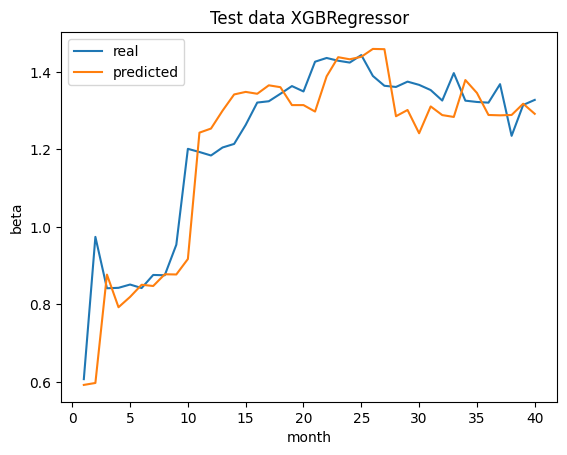

In [60]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_test, label='real')
plt.plot(x,y_pred, label='predicted')
plt.xlabel('month')
plt.ylabel('beta')
plt.legend()
plt.title('Test data XGBRegressor')
plt.show()

In [56]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [57]:
print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 0.009283930050459658
MAE: 0.06533374493695131
R^2: 0.8003859532775042


## Bulding LSTM network

In [63]:
model = Sequential()
model.add(LSTM(100, return_sequences=True, input_shape=(X_train.shape[1], 1)))
model.add(LSTM(100, return_sequences=False))
model.add(Dense(25))
model.add(Dense(1))
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_2 (LSTM)               (None, 5, 100)            40800     
                                                                 
 lstm_3 (LSTM)               (None, 100)               80400     
                                                                 
 dense_3 (Dense)             (None, 25)                2525      
                                                                 
 dense_4 (Dense)             (None, 1)                 26        
                                                                 
Total params: 123,751
Trainable params: 123,751
Non-trainable params: 0
_________________________________________________________________


In [64]:
model.compile(optimizer='adam', loss='mean_squared_error')
model.fit(X_train, y_train, batch_size= 1, epochs=3)

Epoch 1/3
160/160 [==============================] - 3s 4ms/step - loss: 0.0419
Epoch 2/3
160/160 [==============================] - 1s 4ms/step - loss: 0.0144
Epoch 3/3
160/160 [==============================] - 1s 4ms/step - loss: 0.0087


In [65]:
y_pred = model.predict(X_train)

5/5 [==============================] - 1s 4ms/step


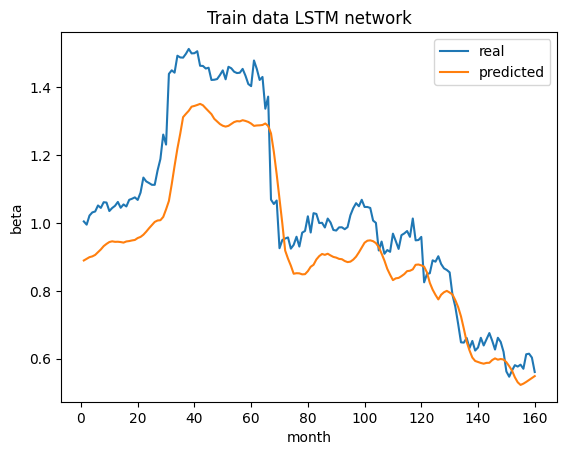

In [66]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x, y_train, label='real')
plt.plot(x, y_pred, label='predicted')
plt.xlabel('month')
plt.ylabel('beta')
plt.legend()
plt.title('Train data LSTM network')
plt.show()

In [68]:
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)
print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 0.014705972299553888
MAE: 0.10629278377049074
R^2: 0.8018663506866446


In [69]:
y_pred = model.predict(X_test)

2/2 [==============================] - 1s 0s/step


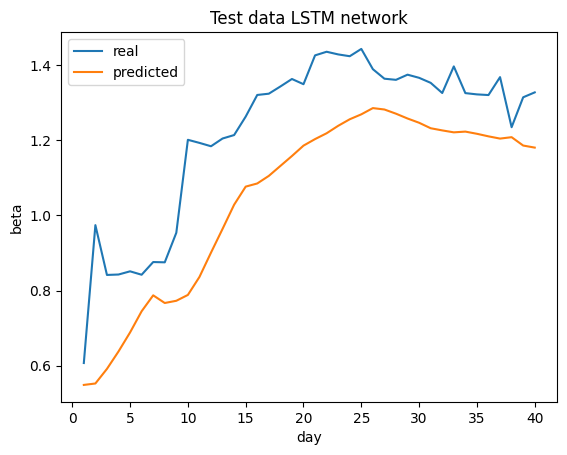

In [70]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_test, label='real')
plt.plot(x,y_pred, label='predicted')
plt.xlabel('day')
plt.ylabel('beta')
plt.legend()
plt.title('Test data LSTM network')
plt.show()

In [71]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [72]:
print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 0.03740755196735818
MAE: 0.17344475140732948
R^2: 0.19569915051043263


## Bulding Linear regression model

In [74]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [84]:
y_pred = model.predict(X_train)

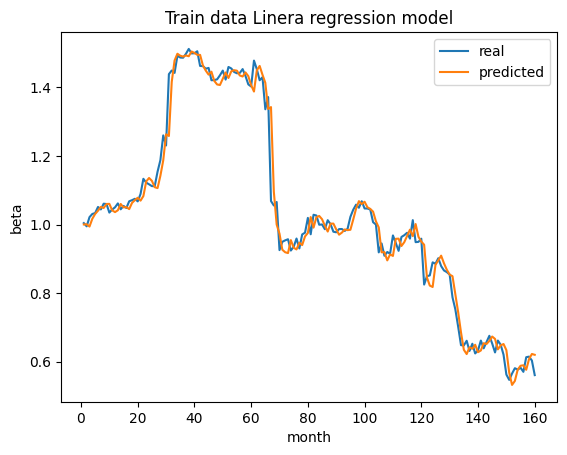

In [85]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x, y_train, label='real')
plt.plot(x, y_pred, label='predicted')
plt.xlabel('month')
plt.ylabel('beta')
plt.legend()
plt.title('Train data Linera regression model')
plt.show()

In [86]:
mse = mean_squared_error(y_train, y_pred)
mae = mean_absolute_error(y_train, y_pred)
r2 = r2_score(y_train, y_pred)

print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 0.0015651752213102863
MAE: 0.02507215491415426
R^2: 0.9789123852475601


In [87]:
y_pred = model.predict(X_test)

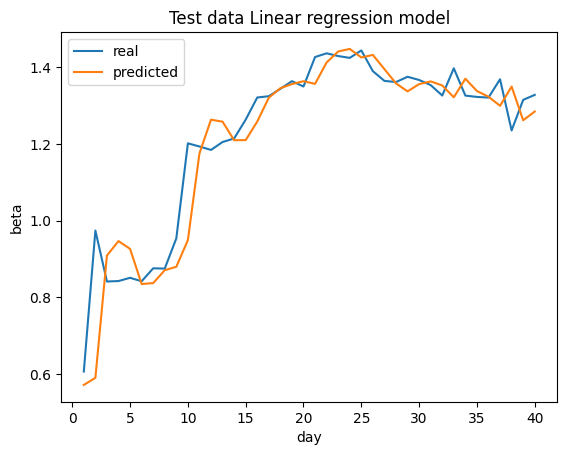

In [88]:
x = np.arange(1, len(y_pred) + 1)
plt.plot(x,y_test, label='real')
plt.plot(x,y_pred, label='predicted')
plt.xlabel('day')
plt.ylabel('beta')
plt.legend()
plt.title('Test data Linear regression model')
plt.show()

In [89]:
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

In [90]:
print("MSE:", mse)
print("MAE:", mae)
print("R^2:", r2)

MSE: 0.0074603474249556575
MAE: 0.051609156238733724
R^2: 0.8395948556961157


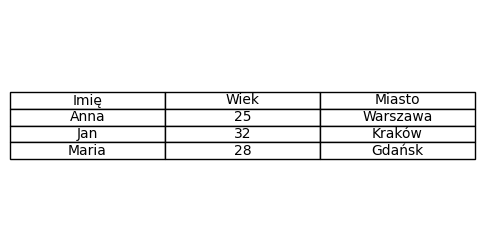

In [91]:
import pandas as pd
import matplotlib.pyplot as plt

# Tworzenie tabeli
data = {'Imię': ['Anna', 'Jan', 'Maria'],
        'Wiek': [25, 32, 28],
        'Miasto': ['Warszawa', 'Kraków', 'Gdańsk']}

df = pd.DataFrame(data)

# Tworzenie wykresu tabeli
fig, ax = plt.subplots(figsize=(6, 3))  # Ustalenie rozmiaru wykresu
ax.axis('off')  # Wyłączenie osi

table = ax.table(cellText=df.values, colLabels=df.columns, cellLoc='center', loc='center')